# 对隐含波动率曲面的特征进行分析

## 准备工作

In [1]:
# 导入必要的库

import pandas as pd
from scipy import stats
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import os

import warnings
warnings.filterwarnings('ignore')
os.chdir('ruc_程序设计大作业/code/data')

In [2]:
def adf_test(data):
    result = adfuller(data) # 知识点：adfuller函数用于ADF检验
    return result[1]

In [3]:
# 读取数据
option_data_pricing = pd.read_csv('./processed_raw/option_data_pricing.csv')
option_data_info = pd.read_csv('./processed_raw/option_data_info.csv')

selCol = ['datetime', 'impliedVol', 'expiration_order', 'strike_price_order', 'maturity', 'moneyness', 'option_type']
option_data = pd.merge(option_data_pricing, option_data_info, on=['datetime', 'StockName'])[selCol] # 知识点：merge函数用于合并数据，通过on和how参数指定合并列和方式

option_data

,datetime,impliedVol,expiration_order,strike_price_order,maturity,moneyness,option_type
0,2015-02-09,0.311728,0.0,-3,0.111111,0.941183,购
1,2015-02-09,0.300918,0.0,-2,0.111111,0.962573,购
2,2015-02-09,0.321756,0.0,-1,0.111111,0.983964,购
3,2015-02-09,0.312342,0.0,0,0.111111,1.005354,购
4,2015-02-09,0.314667,0.0,1,0.111111,1.026745,购
...,...,...,...,...,...,...,...
291445,2024-06-21,0.166545,3.0,-1,0.503968,1.029466,沽
291446,2024-06-21,0.171626,3.0,-2,0.503968,1.049651,沽
291447,2024-06-21,0.177359,3.0,-3,0.503968,1.069837,沽
291448,2024-06-21,0.181613,3.0,-4,0.503968,1.090023,沽


## 曲面的平移-平值（at-the-money,atm）隐含波动率

In [4]:
atm_opt = option_data[(option_data.strike_price_order == 0 ) & (option_data.datetime >= '2000-01-02')].reset_index(drop=True)
call_cur_opt = atm_opt[(atm_opt.option_type == '购') & (atm_opt.expiration_order == 0)].reset_index(drop=True)
put_cur_opt = atm_opt[(atm_opt.option_type == '沽') & (atm_opt.expiration_order == 0)].reset_index(drop=True)
call_next_opt = atm_opt[(atm_opt.option_type == '购') & (atm_opt.expiration_order == 1)].reset_index(drop=True)
put_next_opt = atm_opt[(atm_opt.option_type == '沽') & (atm_opt.expiration_order == 1)].reset_index(drop=True)
call_season_opt = atm_opt[(atm_opt.option_type == '购') & (atm_opt.expiration_order == 2)].reset_index(drop=True)
put_season_opt =atm_opt[(atm_opt.option_type == '沽') & (atm_opt.expiration_order == 2)].reset_index(drop=True)
call_far_opt = atm_opt[(atm_opt.option_type == '购') & (atm_opt.expiration_order == 3)].reset_index(drop=True)
put_far_opt = atm_opt[(atm_opt.option_type == '沽') & (atm_opt.expiration_order == 3)].reset_index(drop=True)

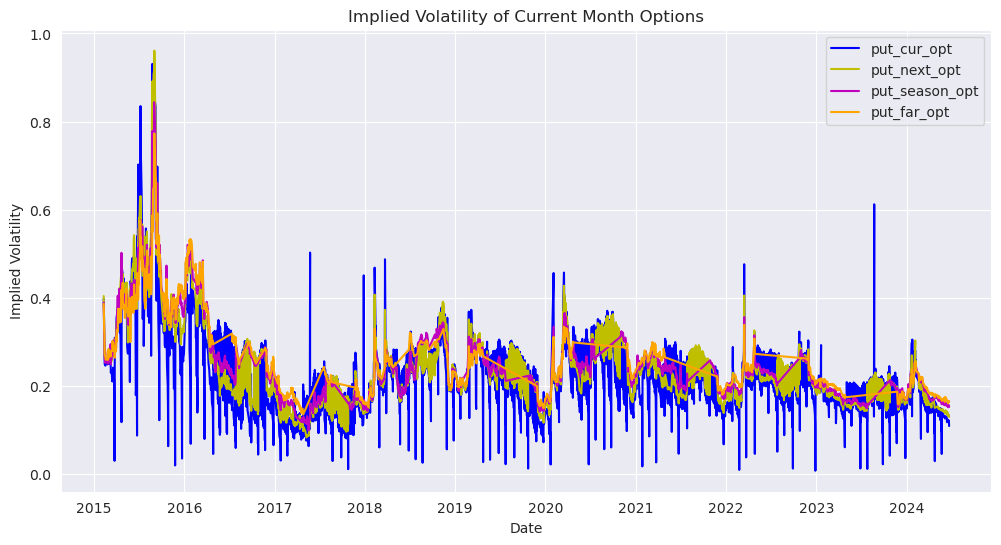

In [5]:
# 可视化近月期权隐含波动率
fig = plt.figure(figsize=(12, 6))
#plt.plot(pd.to_datetime(call_cur_opt.datetime), call_cur_opt.impliedVol, label='call_cur_opt', color='r')
plt.plot(pd.to_datetime(put_cur_opt.datetime), put_cur_opt.impliedVol, label='put_cur_opt', color='b')
#plt.plot(pd.to_datetime(call_next_opt.datetime), call_next_opt.impliedVol, label='call_next_opt', color='g')
plt.plot(pd.to_datetime(put_next_opt.datetime), put_next_opt.impliedVol, label='put_next_opt', color='y')
#plt.plot(pd.to_datetime(call_season_opt.datetime), call_season_opt.impliedVol, label='call_season_opt', color='c')
plt.plot(pd.to_datetime(put_season_opt.datetime), put_season_opt.impliedVol, label='put_season_opt', color='m')
#plt.plot(pd.to_datetime(call_far_opt.datetime), call_far_opt.impliedVol, label='call_far_opt', color='k')
plt.plot(pd.to_datetime(put_far_opt.datetime), put_far_opt.impliedVol, label='put_far_opt', color='orange')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility of Current Month Options')
plt.legend()
plt.grid()
plt.show()

In [7]:
atm_opt.to_csv('./surface_features/atm_vol.csv', index=False)

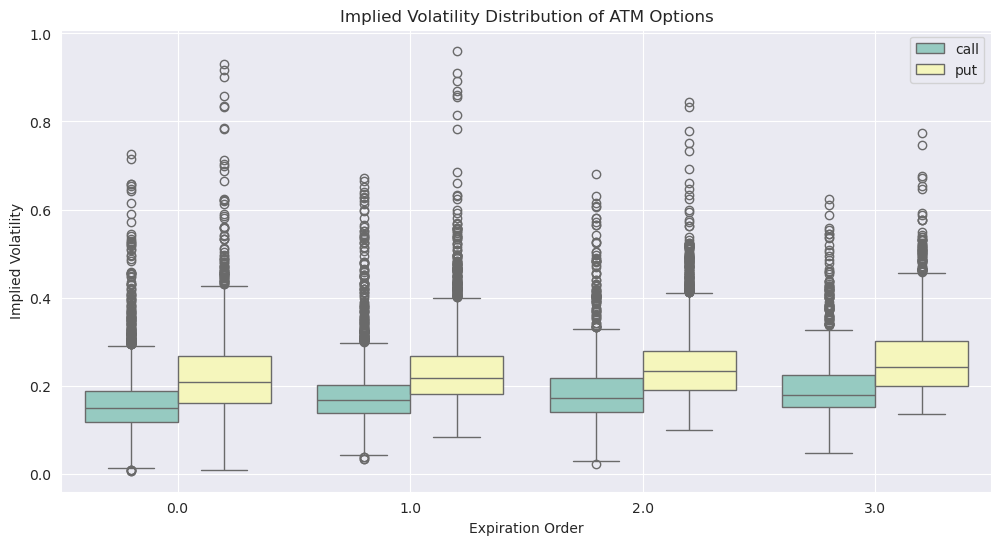

In [23]:
atm_opt.loc[atm_opt.option_type == '购', 'option_type'] = 'call'
atm_opt.loc[atm_opt.option_type == '沽', 'option_type'] = 'put'
# 分布
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='expiration_order', y='impliedVol', data=atm_opt, hue='option_type')
plt.xlabel('Expiration Order')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Distribution of ATM Options')
plt.legend()
plt.grid()
plt.show()

## 曲面的形变-偏度结构

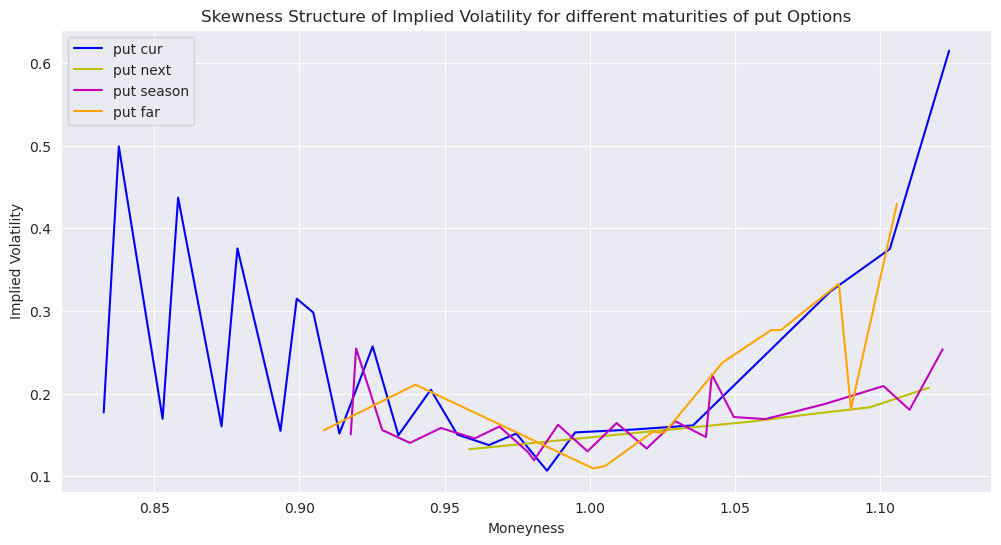

In [8]:
# 偏度结构示例
sample = option_data[(option_data.datetime == '2024-06-21')].reset_index(drop=True)
sample_call_cur = sample[(sample.option_type == '购') & (option_data.expiration_order == 0)].reset_index(drop=True)
sample_put_cur = sample[(sample.option_type == '沽') & (option_data.expiration_order == 0)].reset_index(drop=True)
sample_call_next = sample[(sample.option_type == '购') & (option_data.expiration_order == 1)].reset_index(drop=True)
sample_put_next = sample[(sample.option_type == '沽') & (option_data.expiration_order == 1)].reset_index(drop=True)
sample_call_season = sample[(sample.option_type == '购') & (option_data.expiration_order == 2)].reset_index(drop=True)
sample_put_season = sample[(sample.option_type == '沽') & (option_data.expiration_order == 2)].reset_index(drop=True)
sample_call_far = sample[(sample.option_type == '购') & (option_data.expiration_order == 3)].reset_index(drop=True)
sample_put_far = sample[(sample.option_type == '沽') & (option_data.expiration_order == 3)].reset_index(drop=True)

sample_call_cur.sort_values(by='moneyness', inplace=True)
sample_put_cur.sort_values(by='moneyness', inplace=True)
sample_call_next.sort_values(by='moneyness', inplace=True)
sample_put_next.sort_values(by='moneyness', inplace=True)
sample_call_season.sort_values(by='moneyness', inplace=True)
sample_put_season.sort_values(by='moneyness', inplace=True)
sample_call_far.sort_values(by='moneyness', inplace=True)
sample_put_far.sort_values(by='moneyness', inplace=True)

# 可视化偏度结构
fig = plt.figure(figsize=(12, 6))
#plt.plot(sample_call_cur.moneyness, sample_call_cur.impliedVol, label='call cur', color='r')
plt.plot(sample_put_cur.moneyness, sample_put_cur.impliedVol, label='put cur', color='b')
#plt.plot(sample_call_next.moneyness, sample_call_next.impliedVol, label='call next', color='g')
plt.plot(sample_put_next.moneyness, sample_put_next.impliedVol, label='put next', color='y')
#plt.plot(sample_call_season.moneyness, sample_call_season.impliedVol, label='call season', color='c')
plt.plot(sample_put_season.moneyness, sample_put_season.impliedVol, label='put season', color='m')
#plt.plot(sample_call_far.moneyness, sample_call_far.impliedVol, label='call far', color='k')
plt.plot(sample_put_far.moneyness, sample_put_far.impliedVol, label='put far', color='orange')
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Skewness Structure of Implied Volatility for different maturities of put Options')
plt.legend()
plt.grid()
plt.show()

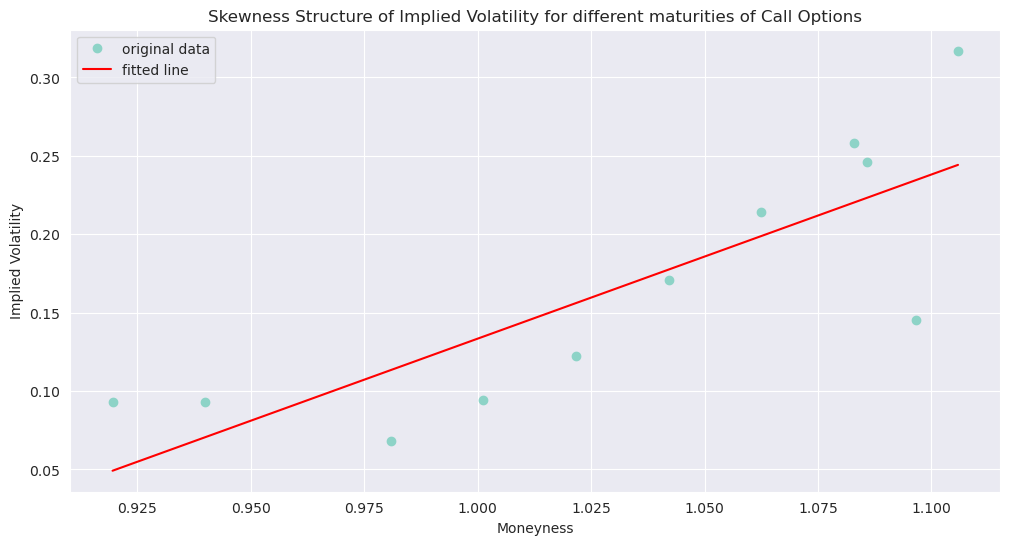

1.046661504765189

In [9]:
# 偏度计算，implied volatility关于moneyness做样条插值
def skewness(data, if_plot=False):
    slope, intercept, r_value, p_value, std_err = linregress(data.moneyness, data.impliedVol) # 知识点：linregress函数用于线性回归
    # 拟合效果
    if if_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(data.moneyness, data.impliedVol, 'o', label='original data')
        plt.plot(data.moneyness, intercept + slope * data.moneyness, 'r', label='fitted line')
        plt.xlabel('Moneyness')
        plt.ylabel('Implied Volatility')
        plt.title('Skewness Structure of Implied Volatility for different maturities of Call Options')
        plt.legend()
        plt.grid()
        plt.show()
    return slope

skewness(sample_call_cur, if_plot=True)

In [10]:
# 计算偏度序列
skew_df = option_data.groupby(['datetime', 'option_type', 'expiration_order']).apply(skewness).reset_index()
skew_df.columns = ['datetime', 'option_type', 'expiration_order', 'skewness']
skew_df.fillna(0, inplace=True) # 知识点：fillna()函数的使用，将缺失值填充为0
skew_df.to_csv('./surface_features/skewness.csv', index=False)
skew_df.head()

,datetime,option_type,expiration_order,skewness
0,2015-02-09,沽,0.0,0.003347
1,2015-02-09,沽,1.0,0.187334
2,2015-02-09,沽,2.0,-0.105508
3,2015-02-09,沽,3.0,0.159310
4,2015-02-09,购,0.0,0.080895


In [11]:
# adf
print(adf_test(skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 0)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 0)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 1)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 1)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 2)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 2)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 3)].skewness))
print(adf_test(skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 3)].skewness))

1.5923214441353633e-06
3.913427436876086e-11
6.056381687737001e-27
4.513597605053375e-10
1.2387801267632055e-29
1.8822825236488342e-06
2.7313515467997325e-12
1.4943723550915433e-05


## 曲面的形变-期限结构

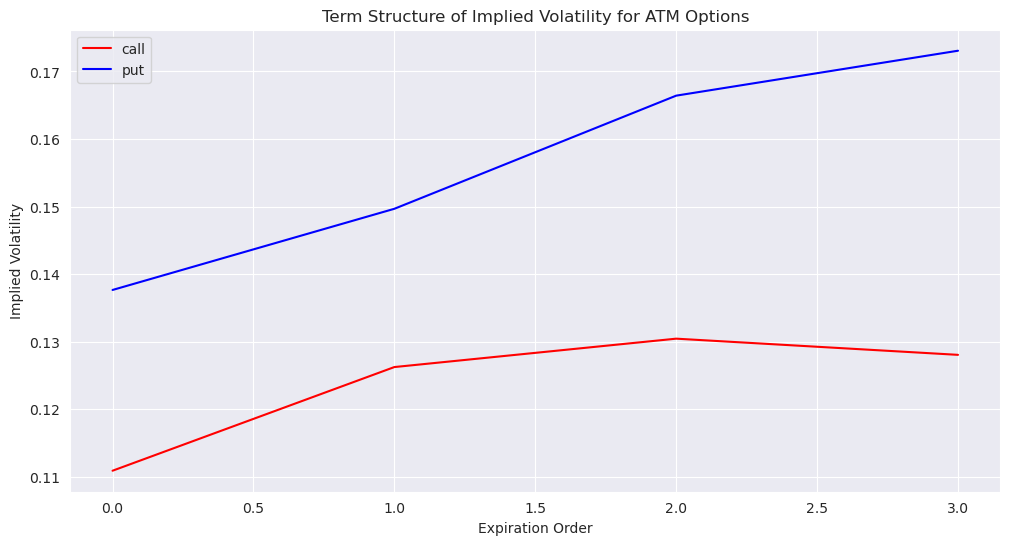

In [12]:
# 期限结构示例
sample = option_data[(option_data.datetime == '2024-05-14')].reset_index(drop=True)
atm_sample = sample[(sample.strike_price_order == 0)].reset_index(drop=True)
atm_sample.sort_values(by='expiration_order', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(atm_sample[atm_sample.option_type == '购'].expiration_order, atm_sample[atm_sample.option_type == '购'].impliedVol, label='call', color='r')
plt.plot(atm_sample[atm_sample.option_type == '沽'].expiration_order, atm_sample[atm_sample.option_type == '沽'].impliedVol, label='put', color='b')
plt.xlabel('Expiration Order')
plt.ylabel('Implied Volatility')
plt.title('Term Structure of Implied Volatility for ATM Options')
plt.legend()
plt.grid()
plt.show()

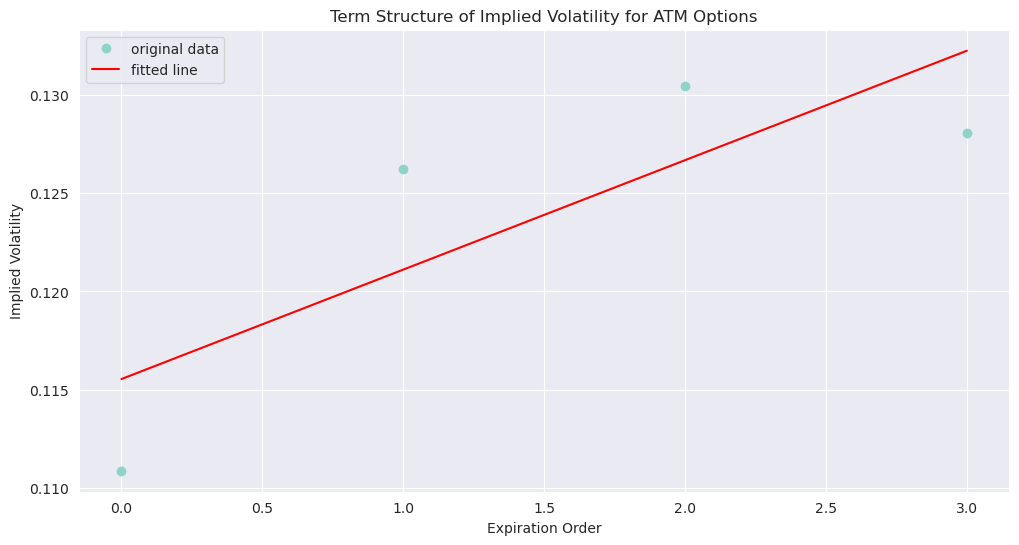

0.005568272781045577

In [13]:
# 期限结构计算
def term_structure(data, if_plot=False):
    if data.shape[0] < 2 or data.expiration_order.nunique() < 2:
        return 0
    slope, intercept, r_value, p_value, std_err = linregress(data.expiration_order, data.impliedVol)
    # 拟合效果
    if if_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(data.expiration_order, data.impliedVol, 'o', label='original data')
        plt.plot(data.expiration_order, intercept + slope * data.expiration_order, 'r', label='fitted line')
        plt.xlabel('Expiration Order')
        plt.ylabel('Implied Volatility')
        plt.title('Term Structure of Implied Volatility for ATM Options')
        plt.legend()
        plt.grid()
        plt.show()
    return slope

term_structure(atm_sample[atm_sample.option_type == '购'], if_plot=True)

In [14]:
atm_term = atm_opt.groupby(['datetime', 'option_type']).apply(term_structure).reset_index()
atm_term.columns = ['datetime', 'option_type', 'atm_term_structure']
atm_term.to_csv('./surface_features/term_structure.csv', index=False)
atm_term.head()

,datetime,option_type,atm_term_structure
0,2015-02-09,沽,-0.004944
1,2015-02-09,购,-0.008254
2,2015-02-10,沽,-0.002487
3,2015-02-10,购,-0.005800
4,2015-02-11,沽,0.005871


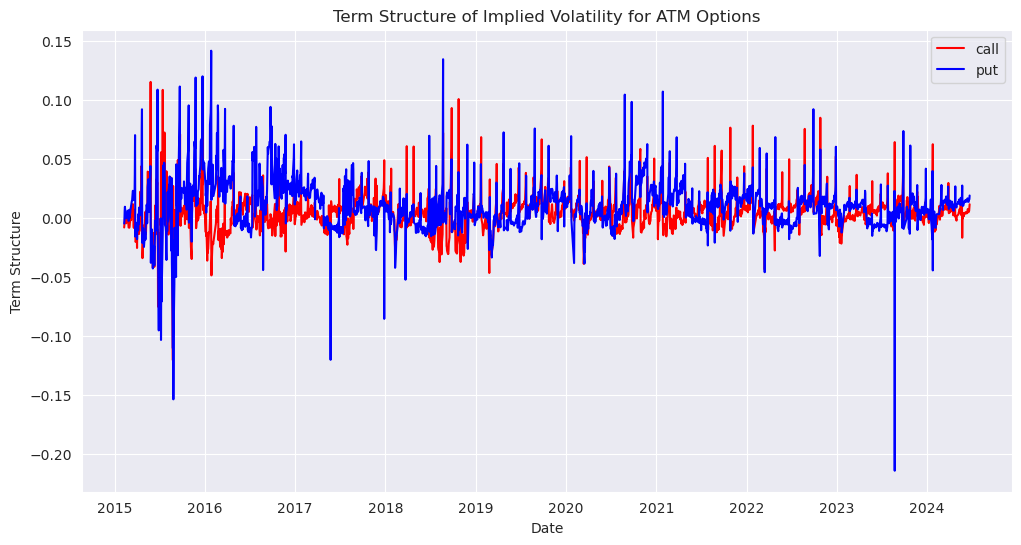

In [15]:
# 可视化
atm_term_call = atm_term[atm_term.option_type == '购']
atm_term_put = atm_term[atm_term.option_type == '沽']

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(atm_term_call.datetime), atm_term_call.atm_term_structure, label='call', color='r')
plt.plot(pd.to_datetime(atm_term_put.datetime), atm_term_put.atm_term_structure, label='put', color='b')
plt.xlabel('Date')
plt.ylabel('Term Structure')
plt.title('Term Structure of Implied Volatility for ATM Options')
plt.legend()
plt.grid()
plt.show()

In [16]:
# adf检验
print(adf_test(atm_term_call.atm_term_structure))
print(adf_test(atm_term_put.atm_term_structure))

5.0308678943515386e-12
0.00019475007779552397


## 期限结构和偏度结构的关联性分析

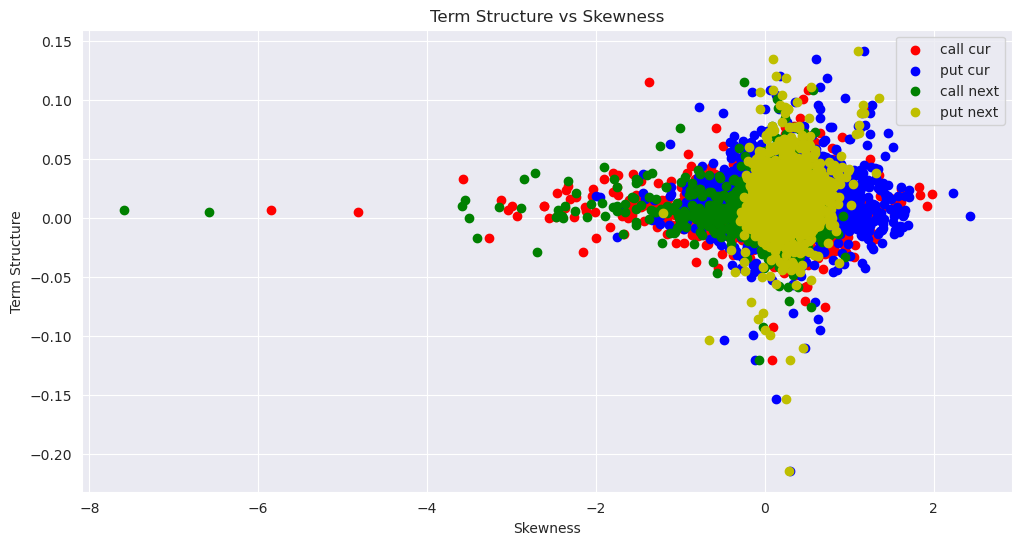

In [17]:
# 散点图分析
skew_cur_call = skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 0)].reset_index(drop=True)
skew_cur_put = skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 0)].reset_index(drop=True)
skew_next_call = skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 1)].reset_index(drop=True)
skew_next_put = skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 1)].reset_index(drop=True)
skew_season_call = skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 2)].reset_index(drop=True)
skew_season_put = skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 2)].reset_index(drop=True)
skew_far_call = skew_df[(skew_df.option_type == '购') & (skew_df.expiration_order == 3)].reset_index(drop=True)
skew_far_put = skew_df[(skew_df.option_type == '沽') & (skew_df.expiration_order == 3)].reset_index(drop=True)
term_cur_call = atm_term[(atm_term.option_type == '购')].reset_index(drop=True)
term_cur_put = atm_term[(atm_term.option_type == '沽')].reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.scatter(skew_cur_call.skewness, term_cur_call.atm_term_structure, label='call cur', color='r')
plt.scatter(skew_cur_put.skewness, term_cur_put.atm_term_structure, label='put cur', color='b')
plt.scatter(skew_next_call.skewness, term_cur_call.atm_term_structure, label='call next', color='g')
plt.scatter(skew_next_put.skewness, term_cur_put.atm_term_structure, label='put next', color='y')
plt.xlabel('Skewness')
plt.ylabel('Term Structure')
plt.title('Term Structure vs Skewness')
plt.legend()
plt.grid()
plt.show()

In [18]:
# 独立性检验
print(stats.pearsonr(skew_cur_call.skewness, term_cur_call.atm_term_structure)) # 知识点：pearsonr()函数用于计算皮尔逊相关系数
print(stats.pearsonr(skew_cur_put.skewness, term_cur_put.atm_term_structure))
print(stats.pearsonr(skew_next_call.skewness, term_cur_call.atm_term_structure))
print(stats.pearsonr(skew_next_put.skewness, term_cur_put.atm_term_structure))

PearsonRResult(statistic=-0.029866964157383255, pvalue=0.15432740132029532)
PearsonRResult(statistic=0.027953806627316165, pvalue=0.1824883288160877)
PearsonRResult(statistic=-0.06088759854249466, pvalue=0.003662077174938167)
PearsonRResult(statistic=0.18405238419875214, pvalue=8.630108224480249e-19)


In [19]:
# 格兰杰因果检验 - 期限结构对偏度的影响

g_df = pd.DataFrame()
g_df['call_cur'] = skew_cur_call.skewness
g_df['put_cur'] = skew_cur_put.skewness
g_df['term_call'] = term_cur_call.atm_term_structure
g_df['term_put'] = term_cur_put.atm_term_structure
g_df.dropna(inplace=True)

grangercausalitytests(g_df[['call_cur', 'term_call']], maxlag=1) # 知识点：grangercausalitytests()函数用于格兰杰因果检验
grangercausalitytests(g_df[['put_cur', 'term_put']], maxlag=1)

# 反向检验
grangercausalitytests(g_df[['term_call', 'call_cur']], maxlag=1)
grangercausalitytests(g_df[['term_put', 'put_cur']], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0323  , p=0.1541  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=2.0350  , p=0.1537  , df=1
likelihood ratio test: chi2=2.0341  , p=0.1538  , df=1
parameter F test:         F=2.0323  , p=0.1541  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0036  , p=0.9523  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=0.0036  , p=0.9523  , df=1
likelihood ratio test: chi2=0.0036  , p=0.9523  , df=1
parameter F test:         F=0.0036  , p=0.9523  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1466  , p=0.7019  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=0.1467  , p=0.7017  , df=1
likelihood ratio test: chi2=0.1467  , p=0.7017  , df=1
parameter F test:         F=0.1466  , p=0.7019  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3510  , p=0.

{1: ({'ssr_ftest': (0.3509685873377196, 0.5536243008885062, 2272.0, 1),
   'ssr_chi2test': (0.3514320141695916, 0.5533036188686711, 1),
   'lrtest': (0.3514048731303774, 0.5533189408425447, 1),
   'params_ftest': (0.3509685873380414, 0.5536243008882209, 2272.0, 1.0)},
   array([[0., 1., 0.]])])}

In [20]:
# 格兰杰因果检验 - 近月和次月
g_df = pd.DataFrame()
g_df['call_next'] = skew_next_call.skewness
g_df['put_next'] = skew_next_put.skewness
g_df['term_call'] = term_cur_call.atm_term_structure
g_df['term_put'] = term_cur_put.atm_term_structure
g_df.dropna(inplace=True)

grangercausalitytests(g_df[['call_next', 'term_call']], maxlag=1) 
grangercausalitytests(g_df[['put_next', 'term_put']], maxlag=1)

# 反向检验
grangercausalitytests(g_df[['term_call', 'call_next']], maxlag=1)
grangercausalitytests(g_df[['term_put', 'put_next']], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5994  , p=0.4389  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=0.6002  , p=0.4385  , df=1
likelihood ratio test: chi2=0.6001  , p=0.4385  , df=1
parameter F test:         F=0.5994  , p=0.4389  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5767  , p=0.2094  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=1.5788  , p=0.2089  , df=1
likelihood ratio test: chi2=1.5783  , p=0.2090  , df=1
parameter F test:         F=1.5767  , p=0.2094  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0809  , p=0.2986  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=1.0823  , p=0.2982  , df=1
likelihood ratio test: chi2=1.0820  , p=0.2982  , df=1
parameter F test:         F=1.0809  , p=0.2986  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.3762 , p=0.

{1: ({'ssr_ftest': (14.376213956577557, 0.00015358248998377936, 2272.0, 1),
   'ssr_chi2test': (14.395196633456841, 0.0001481798061463352, 1),
   'lrtest': (14.349844616906921, 0.00015179222194861423, 1),
   'params_ftest': (14.376213956577823, 0.00015358248998374418, 2272.0, 1.0)},
   array([[0., 1., 0.]])])}